# Startup

In [1]:
!pip install --upgrade llvmlite
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
!pip install top2vec  # easy way to install Top2Vec
!pip install top2vec[sentence_encoders]  # install if using pre-trained universal sentence encoder options
!pip install top2vec[sentence_transformers]  # install if using pre-trained BERT sentence transformer options
!pip install git+https://github.com/MartinoMensio/spacy-universal-sentence-encoder.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-install-e44_4dip/hdbscan_30ce1cb2131146d5be29ae010b5fd377
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-install-e44_4dip/hdbscan_30ce1cb2131146d5be29ae010b5fd377
  Resolved https://github.com/scikit-learn-contrib/hdbscan.git to commit e55f957441fa58c109971fb868a399b498578234
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=3582043 sha256=88897614f2bb7b14d282c0f51b8214216fce8f603ea8bb0420635db17b40aeb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xpvunk62/wheels/d9/a3/52/1cab908

In [4]:
!pip install pandas==1.5.3
import pandas as pd

from top2vec import Top2Vec
import pandas as pd
import numpy as np
import multiprocessing
import time
import csv
import io

#multiprocessing.cpu_count()

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#%cd gdrive/MyDrive/MITB_AI/Text analytics dataset

In [1]:
import joblib
model = joblib.load('Top2VecModel_X_Train.jl')

In [13]:
X_train = pd.read_pickle("X_Train.pkl")

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # min occurrences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

df_filtered_lemmatized = X_train["text_lemmatized"].tolist()

stop_list = ("suicidal", "suicide", "aah", "fuck")
df_filtered_lemmatized_removeSuicide = [[w for w in doc if w not in stop_list] for doc in df_filtered_lemmatized]
df_filtered_lemmatized_joined = [' '.join(x) for x in df_filtered_lemmatized_removeSuicide]  # joined to fit CountVectorizer
train1_vecs = vectorizer.fit_transform(df_filtered_lemmatized_joined) #may be needed for bertopic
feature_names = vectorizer.get_feature_names_out()
# display the first 20 tokens
feature_names[:20]

array(['aaron', 'aba', 'aback', 'abandon', 'abandoned', 'abandonment',
       'abdomen', 'abdominal', 'abhor', 'abhorrent', 'abide', 'ability',
       'abject', 'able', 'abnormal', 'abnormality', 'abnormally',
       'abomination', 'abort', 'aborted'], dtype=object)

# Perplexity

In [ ]:
from nltk.probability import FreqDist
import math
import pickle
from top2vec import Top2Vec
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags


def default_tokenizer(doc):
    # This part was copied from Top2Vec tokenizer, if you are using a specific tokenizer you should not use the default one when computing the measure
    """Tokenize documents for training and remove too long/short words"""
    return simple_preprocess(strip_tags(doc), deacc=True)


def PWI(model, docs, num_topics=10, num_words=50):
    """
    :param model: top2vec model
    :param docs: list of strings
    :param num_topics: number of topics to use in the computation
    :param num_words: number of words to use
    :return: PWI value
    """

    model.hierarchical_topic_reduction(num_topics)

    # This is used to tokenize the data and strip tags (as done in top2vec)
    tokenized_data = [default_tokenizer(doc) for doc in docs]
    # Computing all the word frequencies
    # First I concatenate all the documents and use FreqDist to compute the frequency of each word
    word_frequencies = FreqDist(np.concatenate(tokenized_data))

    # Computing the frequency of words per document
    # Remember to change the tokenizer if you are using a different one to train the model
    dict_docs_freqs = {}
    for i, doc in enumerate(df_filtered_lemmatized_joined):
        counter_dict = FreqDist(default_tokenizer(doc))
        if i not in dict_docs_freqs:
            dict_docs_freqs[i] = counter_dict

    PWI = 0.0
    p_d = 1 / len(docs)
    # This will iterate through the whole dataset and query the topics of each document.
    for i, doc in enumerate(docs):
        topic_words, word_scores, topic_scores, topic_nums = model.query_topics(query=doc, num_topics=num_topics,
                                                                                reduced=True)
        # Words of the topic
        # Topic scores is the topic importance for that document
        for words, t_score in zip(topic_words, topic_scores):
            for word in words[:num_words]:
                if word not in dict_docs_freqs[i]:
                    # This is added just for some specific cases when we are using different collection to test
                    continue
                # P(d,w) = P(d|w) * p(w)
                p_d_given_w = dict_docs_freqs[i].freq(word)
                p_w = word_frequencies.freq(word)
                p_d_and_w = p_d_given_w * p_w
                left_part = p_d_given_w * t_score
                PWI += left_part * math.log(p_d_and_w / (p_w * p_d))
    return PWI

if __name__ == '__main__':
    print("PWI:", PWI(model=model, docs=df_filtered_lemmatized_joined, num_topics=10, num_words=50))

PWI: 13248.085330232427


# Log likelyhood

In [ ]:
print(len(tokenized_data))

NameError: ignored

Coherence


In [ ]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_column):
  topics = model.topic_words

  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_column]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the topics attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [ ]:
coherence = get_Cv(df_column=df_filtered_lemmatized_joined, model=model)

In [ ]:
print(coherence)

# Explained Variance Ratio (EVR)

Data prep

In [21]:
topic_scores = pd.read_csv('Top2Vec_X_Train_RawTopicsScores.csv', index_col=0)
topic_scores.head(1)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49
Topic 0,0.360479,0.336755,0.319646,0.319498,0.317781,0.311918,0.310313,0.295974,0.295076,0.29425,...,0.262586,0.26258,0.262369,0.262007,0.261937,0.26148,0.260463,0.259567,0.258271,0.257693


In [22]:
test = [x for x in X_train['text'].map(lambda x: str(x).lower())]
test1 = ' '.join(test)

vocab = model.vocab
vocab1 = ' '.join(vocab)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

term_frequency = vectorizer.fit_transform([test1, vocab1])

In [19]:
from tqdm import tqdm

#X_train = pd.read_pickle("X_Train_nonSuicidal.pkl")
reduced = False

#vocab
vocab = model.vocab

#doc_topic_dists
epsilon = 1e-8
topic_term_dists = np.empty([model.get_num_topics(reduced=reduced), len(vocab)])

topic_term_dists_norm = topic_term_dists / (topic_term_dists.sum(axis=1, keepdims=True) + epsilon)

#probs

#doc_lengths
stop_list = ("suicidal", "suicide", "aah", "fuck", "fucking", "na")
text_data = X_train['text_lemmatized'].to_numpy()
text_data = [[w for w in doc if w not in stop_list] for doc in text_data]
doc_lengths = [len(doc) for doc in text_data]

#doc_topic_dists = np.hstack((new_probs, outlier))
doc_topic_dists = model._calculate_documents_topic


#term_frequency
#term_frequency = [model.vectorizer_model.vocabulary_[word] for word in vocab]


for w in tqdm(vocab, total=len(vocab)):
    _, _, word_scores, _ = model.search_topics(keywords=[w], num_topics=model.get_num_topics(reduced=reduced), reduced=reduced)
    topic_term_dists = np.concatenate((topic_term_dists, word_scores[:,np.newaxis]), axis=1)
print(topic_term_dists)

100%|██████████████████████████████████████████████████████████████████████████████| 5355/5355 [01:42<00:00, 52.36it/s]

[[ 0.          0.          0.         ...  0.20324378  0.19163811
   0.39998826]
 [ 0.          0.          0.         ...  0.13739777  0.1789404
   0.26340594]
 [ 0.          0.          0.         ...  0.13209575  0.13741615
   0.25597227]
 ...
 [ 0.          0.          0.         ... -0.16214575 -0.16920124
  -0.14712475]
 [ 0.          0.          0.         ... -0.17085992 -0.16998547
  -0.15125945]
 [ 0.          0.          0.         ... -0.182418   -0.17017906
  -0.15517268]]


# pyLDavis

In [44]:
model.hierarchical_topic_reduction(num_topics=15)

[[182,
  636,
  16,
  8,
  99,
  135,
  32,
  47,
  956,
  529,
  274,
  339,
  589,
  409,
  791,
  688,
  805,
  519,
  670,
  986,
  71,
  223,
  253,
  232,
  1112,
  61,
  323,
  478,
  348,
  1143,
  995,
  757,
  1153,
  1115,
  127,
  1144,
  521,
  364,
  1052,
  806,
  433,
  686,
  1107,
  837,
  1079,
  533,
  222,
  416,
  427,
  694,
  56,
  1031,
  190,
  591,
  460,
  44,
  597,
  778,
  289,
  449,
  1098,
  663,
  159,
  1076,
  180,
  408,
  1046,
  550,
  865,
  277,
  976,
  726,
  1084,
  884,
  877,
  819,
  558,
  526,
  817,
  883,
  407,
  1130,
  235,
  893,
  885,
  781,
  895,
  758,
  1014,
  282,
  1042,
  658,
  948,
  1019,
  1152,
  1110,
  801,
  374,
  479,
  764,
  467,
  243,
  69,
  293,
  426,
  723,
  797,
  942,
  494,
  474,
  458,
  961,
  951,
  425,
  899,
  756,
  417,
  1034,
  631,
  999,
  1036,
  1006,
  332,
  786,
  595,
  561,
  940,
  469,
  914,
  571,
  1145,
  943,
  1055,
  882,
  315,
  377,
  259,
  772,
  1038,
  1099,
  212

In [1]:
#!pip install pyldavis pyLDAvis==3.4.0
import pyLDAvis
#from pyLDAvis import ldalearn
#import pyLDAvis.Top2Vec
pyLDAvis.enable_notebook()
from platform import python_version
print(python_version())


3.9.16


In [45]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np
import pandas as pd

# assume `model` is your Top2Vec model
topic_sizes, topic_nums = model.get_topic_sizes()
topic_words, word_scores, topic_nums = model.get_topics()

n_topics = len(topic_words)
n_words = max([len(words) for words in topic_words])

# form topic-word matrix
n_topics = len(topic_words)
n_words = max([len(words) for words in topic_words])
topic_word_matrix = np.zeros((n_topics, n_words), dtype='object')
for i, words in enumerate(topic_words):
    topic_word_matrix[i, :len(words)] = words

# create pandas dataframe from topic-word matrix
df_topic_word = pd.DataFrame(topic_word_matrix, 
                             columns=[f'Word {i}' for i in range(n_words)], 
                             index=[f'Topic {i}' for i in range(n_topics)])

#df_topic_word.index.name = 'topic'
df_topic_word_small = df_topic_word.iloc[:, :15]
# show dataframe
df_topic_word_small.head(10)



,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,element,impression,christianity,justice,beneath,exploit,acted,empathize,unbelievable,volume,naturally,gently,cultural,mortal,exception
Topic 1,wish,wrong,hurt,should,need,selfish,want,would,instead,love,actually,expect,maybe,happy,know
Topic 2,semester,spa,retake,exam,class,university,academic,physic,assignment,graduate,professor,engineering,study,score,student
Topic 3,rent,payment,loan,bill,debt,bank,credit,saving,pay,evict,afford,income,owe,unemployment,utility
Topic 4,hire,interview,manager,bos,resume,employee,apply,job,company,customer,unemployment,employer,retail,employment,fired
Topic 5,wrist,blade,razor,knife,bleed,slit,sharp,vein,artery,cut,arm,slice,forearm,wrists,bathtub
Topic 6,dysphoria,trans,transgender,transition,gender,hormone,phobic,ftp,mtg,masculine,binary,male,female,puberty,testosterone
Topic 7,noose,neck,belt,knot,tie,rope,tighten,chair,cord,hang,choke,suspension,ceiling,wrap,strangle
Topic 8,na,wan,gon,fucking,yeah,anyways,tho,bye,pussy,fucker,lao,ta,wish,kinda,till
Topic 9,sexually,assault,abused,rap,rape,molest,abuse,sexual,abusive,assaulted,verbally,harass,abuser,rapist,raped


In [46]:

# infer topic distribution for each document
doc_topics, doc_ids = [], []
for i, doc in enumerate(df_filtered_lemmatized_joined):
    topic_words, word_scores, topic_scores, topic_nums = model.query_topics(doc, 15)
    doc_topics.append(topic_scores)
    doc_ids.append(i)

# form document-topic matrix
doc_topic_matrix = np.array(doc_topics)

# create a pandas DataFrame from the matrix
df_doc_topic = pd.DataFrame(doc_topic_matrix, 
                             columns=[f'Topic {i}' for i in range(doc_topic_matrix.shape[1])], 
                             index=[f'Doc {i}' for i in range(doc_topic_matrix.shape[0])])

# print the dataframe
print(df_doc_topic.head())

        Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
Doc 0  0.775339  0.496678  0.172697  0.140206  0.095723  0.052756  0.047671   
Doc 1  0.315452  0.219575  0.179233  0.167821  0.164373  0.161908  0.160931   
Doc 2  0.430338  0.313079  0.311179  0.302008  0.299390  0.250893  0.244582   
Doc 3  0.517418  0.365423  0.352318  0.333346  0.285922  0.285828  0.283220   
Doc 4  0.327693  0.291421  0.230876  0.230159  0.223917  0.221784  0.203820   

        Topic 7   Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  \
Doc 0  0.022218  0.018631  0.016113  0.010522  0.009015  0.003913 -0.003103   
Doc 1  0.160831  0.157868  0.155629  0.153386  0.153105  0.147027  0.145350   
Doc 2  0.242427  0.240121  0.238905  0.231266  0.228939  0.227504  0.221437   
Doc 3  0.245792  0.229995  0.228903  0.228359  0.227856  0.218722  0.213830   
Doc 4  0.200521  0.198136  0.194522  0.190588  0.186658  0.184949  0.183433   

       Topic 14  
Doc 0 -0.003574  
Doc 1  0.14425

[32424.69  26610.025 24164.154 22682.133 21623.496 20817.863 20171.521
 19633.264 19173.336 18774.664 18423.896 18109.111 17826.184 17570.87
 17335.73 ]


IndexError: index 15 is out of bounds for axis 0 with size 15

In [ ]:

# create pyLDAvis visualization
vis_data = pyLDAvis.prepare(
    topic_word_matrix, doc_topic_matrix, n_topics, vocab, term_freq_dict
)

pyLDAvis.display(vis_data)

In [ ]:
pyLDAvis.save_html(panel, 't2v_nonSuicidal.html')

NameError: ignored

In [17]:
# Construct the k-means clusters
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


clusters = KMeans(n_clusters=10, random_state=100).fit_predict(topic_scores)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
t2v_output_svd = svd_model.fit_transform(topic_scores)
# X and Y axes of the plot using SVD decomposition
x = t2v_output_svd[:, 0]
y = t2v_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))    

NameError: name 'topic_scores' is not defined

Text(0.5, 1.0, 'Segregation of Topic Clusters')

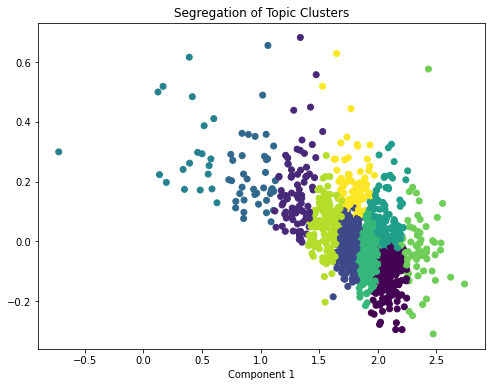

In [ ]:
import matplotlib.pyplot as plot

plot.figure(figsize=(8,6))
plot.scatter(x, y, c=clusters)
plot.xlabel('Component 2')
plot.xlabel('Component 1')
plot.title("Segregation of Topic Clusters", )

# pyLDAvis 2

In [11]:
print(list(X_train['text']))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
df = X_train

vectorized_data = model.topic_vectors

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Create Top2Vec model
model = Top2Vec(documents=list(X_train['text']), speed="learn", workers=4)


2023-03-17 02:44:17,744 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-03-17 02:44:35,467 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-17 03:05:20,792 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-17 03:07:00,029 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-17 03:07:13,382 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


NameError: ignored

In [29]:
print(topic_term_dists)

[[ 0.          0.          0.         ...  0.13562448  0.13479745
   0.12481832]
 [ 0.          0.          0.         ...  0.1281065   0.13187556
   0.11359803]
 [ 0.          0.          0.         ...  0.12742832  0.12831943
   0.1062507 ]
 ...
 [ 0.          0.          0.         ... -0.14266332 -0.15786036
  -0.14899088]
 [ 0.          0.          0.         ... -0.17427013 -0.16580379
  -0.15303431]
 [ 0.          0.          0.         ... -0.17539625 -0.17629394
  -0.1603847 ]]


In [32]:
!pip install pyldavis pyLDAvis==3.4.0
import pyLDAvis
import pyLDAvis.lda_model
from tqdm import tqdm
from sklearn.decomposition import PCA

vectorized_data = np.asarray(topic_term_dists)

pca = PCA()
fit = pca.fit(vectorized_data)

# Visualize topics with PyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(model.model, vectorized_data, vectorizer)
#pyLDAvis.lda_model.prepare(model.model, fit.components_, vectorizer)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AttributeError: ignored

# **Querying new document topic**

In [ ]:
#https://github.com/ddangelov/Top2Vec/issues/218

Initialization

In [ ]:
!pip install --upgrade llvmlite
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
!pip install top2vec  # easy way to install Top2Vec
!pip install top2vec[sentence_encoders]  # install if using pre-trained universal sentence encoder options
!pip install top2vec[sentence_transformers]  # install if using pre-trained BERT sentence transformer options
!pip install git+https://github.com/MartinoMensio/spacy-universal-sentence-encoder.git

In [ ]:
!pip install pandas==1.5.3
import pandas as pd

from top2vec import Top2Vec
import pandas as pd
import numpy as np
import multiprocessing
import time
import csv
import io

multiprocessing.cpu_count()


from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/MITB_AI/Text analytics dataset

In [ ]:
import joblib
model = joblib.load('Top2VecModel_X_Train.jl')

Topic prediction

In [ ]:
#document loading

query = [""" i wanna jump from an elevated place. i wanna kill myself, like really really would like to jump off an elevated place, 
             but not die what do i do? drugs? fall from somewhere not far above the ground(like a 4meters jump)? 
             you know, i'd just like to die but i have a gr8 life other than that 
             (I have different lives in two different countries, just want to kill myself in one)
         """]

In [ ]:
#query topics
#synax: model.query_topics(query, num_topics, reduced=False,tokenizer=False)

test = model.query_topics(str(query), 1)
print(test)

([array(['kill', 'alive', 'dy', 'die', 'murder', 'shall', 'shadow', 'fry',
       'knife', 'death', 'pen', 'burger', 'tonight', 'stab', 'imposter',
       'soldier', 'aha', 'sock', 'drip', 'verse', 'disappear', 'killer',
       'olive', 'sauce', 'thee', 'titan', 'army', 'sacrifice', 'dark',
       'adam', 'meat', 'soul', 'villain', 'flesh', 'cast', 'egg',
       'crisis', 'spider', 'ping', 'jam', 'lord', 'beat', 'diamond',
       'noe', 'scene', 'bacon', 'frank', 'dead', 'mosquito', 'breathe'],
      dtype='<U14')], [array([0.40634707, 0.23931864, 0.22156478, 0.19642618, 0.18770346,
       0.18240583, 0.18034066, 0.17736284, 0.17550786, 0.17209162,
       0.16930209, 0.16037412, 0.15950449, 0.15803885, 0.15703094,
       0.1563761 , 0.15363781, 0.15183659, 0.14607729, 0.13512604,
       0.13308348, 0.13192964, 0.1286598 , 0.12784174, 0.12103041,
       0.1209419 , 0.11947642, 0.11861806, 0.11634339, 0.1146384 ,
       0.11404468, 0.11387464, 0.11370419, 0.11326906, 0.11277709,
       0

In [ ]:
print(model.topic_vectors[0])

[ 0.07142367 -0.03739461 -0.01637692 -0.00499416 -0.05622268  0.04850825
 -0.01572226 -0.03950674 -0.05187721  0.06315181 -0.05276074 -0.00971884
  0.01397903  0.07486025 -0.04206357  0.04940495 -0.11306393  0.05576791
  0.07908081 -0.05190374 -0.04548836  0.02100289 -0.09391727 -0.06043105
  0.08642192 -0.07001664 -0.07104605 -0.01564488 -0.03038756 -0.02470852
 -0.00048012  0.04598869  0.04392067  0.00279237 -0.01118814 -0.0684253
 -0.08018004  0.13339403  0.09433211 -0.04295995 -0.02493032 -0.00321045
 -0.00096681  0.09462185 -0.0586817   0.02030998 -0.04304455  0.04997921
  0.06816567  0.01166828 -0.04952926  0.00146428  0.02865209  0.09191611
  0.03141327 -0.03871601 -0.00642147 -0.08495484 -0.07146402  0.0187152
 -0.06193272 -0.04488738 -0.08515532  0.04222178 -0.06379573  0.07033119
  0.01265087 -0.07333585  0.00651488  0.07928132 -0.03443215 -0.03439803
  0.03683292 -0.04083345 -0.03111916  0.05221812  0.03582158 -0.03841264
  0.02475327  0.01955468  0.03777918 -0.05118054 -0.0

# Vector visualization

In [ ]:
#vector visualization
import umap
docs_reduced = umap.UMAP(n_components=2, 
                         n_neighbors=15, 
                         metric="cosine", 
                         min_dist=.10, 
                         random_state=42, 
                         verbose=True).fit_transform(model.topic_vectors)
x, y = docs_reduced[:,0], docs_reduced[:,1]

plt.figure(figsize=(5,5))
plt.scatter(x,y, s=5, alpha=0.75)
#plt.axis("off")
plt.show()